In [1]:
!pip install -qU python-gdcm pylibjpeg

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import cv2
import glob
import gdcm
import pydicom
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from joblib import Parallel, delayed

In [3]:
TEST_PATH = '/kaggle/input/rsna-2023-abdominal-trauma-detection/test_images/'
SAVE_FOLDER = '/kaggle/working/test/'
SIZE = 512
EXTENSION = 'png'

os.makedirs(SAVE_FOLDER, exist_ok = True)

In [4]:
print('Number of test patients:', len(os.listdir(TEST_PATH)))

Number of test patients: 3


In [5]:
def process(patient, size = SIZE, save_folder = "", data_path = ""):
    
    for study in sorted(os.listdir(data_path + patient)):
        imgs = {}
        for f in sorted(glob.glob(data_path + f"{patient}/{study}/*.dcm")):
            
            dicom = pydicom.dcmread(f)
            pos_z = dicom[(0x20, 0x32)].value[-1]
            
            img = dicom.pixel_array
            img = (img - img.min())/(img.max() - img.min() + 1e-6)
            
            imgs[pos_z] = img
        
        for i, k in enumerate(sorted(imgs.keys())):
            
            img = imgs[k]
            
            img = cv2.resize(img, (size, size))
            cv2.imwrite(save_folder + f"{patient}_{study}_{i}.png", (img * 255).astype(np.uint8))

            
            

In [6]:
patients = os.listdir(TEST_PATH)

In [7]:
for patient in tqdm(patients):
    process(patient, size=512, save_folder=SAVE_FOLDER, data_path=TEST_PATH)

  0%|          | 0/3 [00:00<?, ?it/s]

In [8]:
#!pip uninstall opencv-python 
#!pip install opencv-python

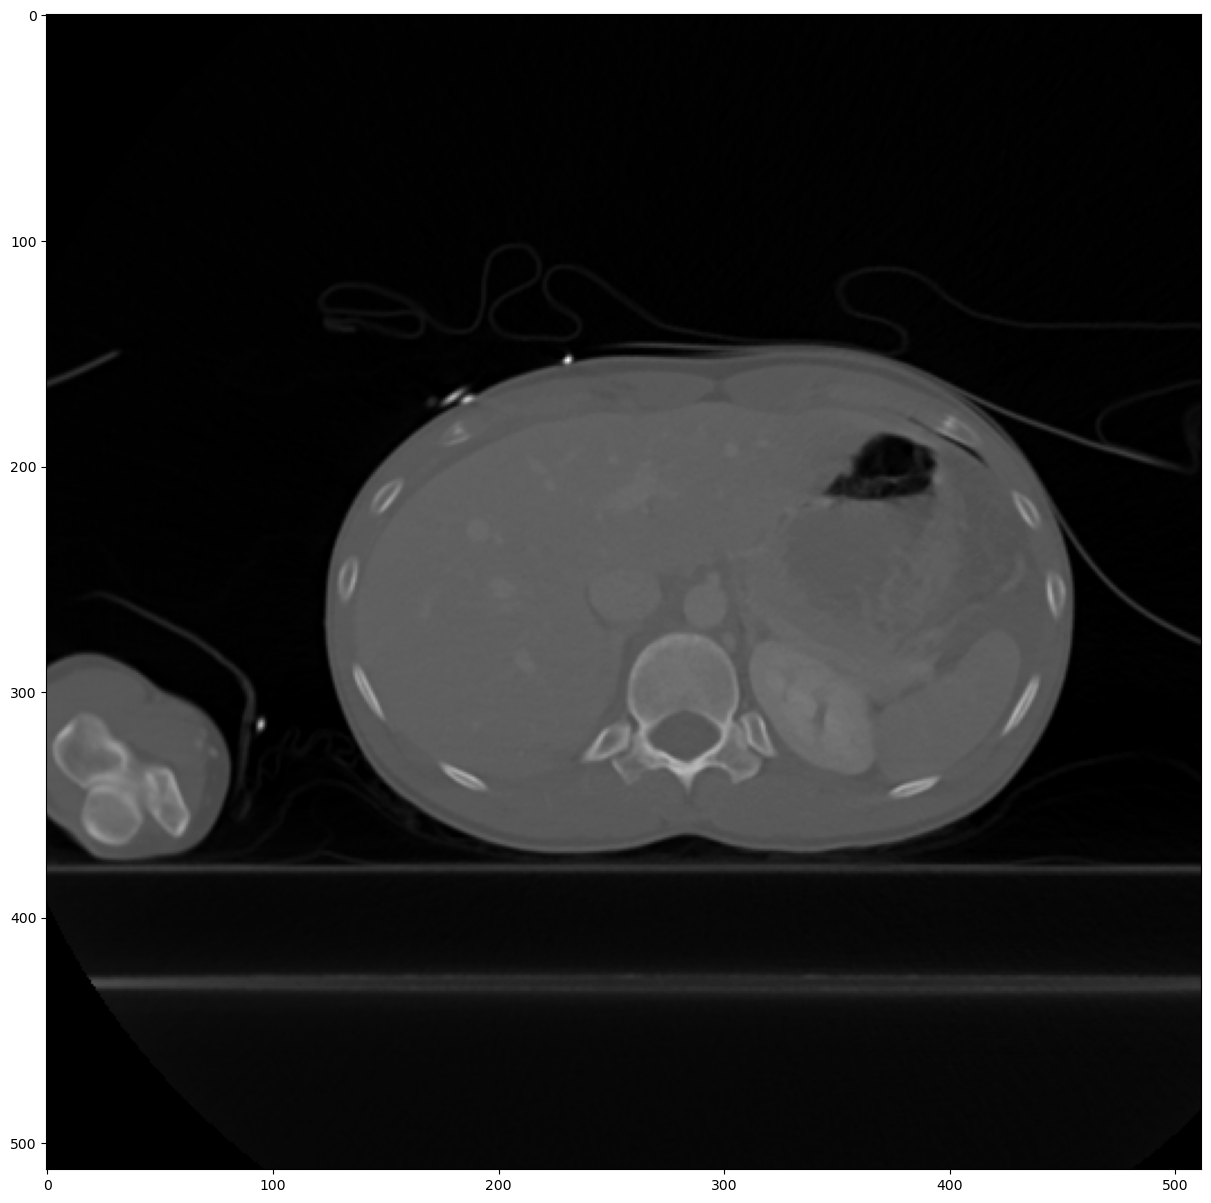

In [9]:
img = cv2.imread('/kaggle/working/test/48843_62825_0.png', 0)
#cv2.imshow('image', img)

plt.figure(figsize=(15, 15))
plt.imshow(img, cmap="gray")
plt.show()